In [ ]:
import os
import pandas as pd
import json
import gzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
print(os.listdir())

['.config', 'drive', 'sample_data']


In [ ]:
!pip install evaluate

In [ ]:
import evaluate

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np


In [ ]:
from datasets import load_dataset

ds = load_dataset("nikesh66/Sarcasm-dataset")

In [ ]:
def add_label(example):
    example["label"] = 1 if example["Sarcasm (yes/no)"] == "yes" else 0
    return example

ds = ds.map(add_label)

In [ ]:
sarcasm_ds = ds["train"].train_test_split(test_size=0.2, seed=42)

print(sarcasm_ds)

DatasetDict({
    train: Dataset({
        features: ['Tweet', 'Sarcasm (yes/no)', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['Tweet', 'Sarcasm (yes/no)', 'label'],
        num_rows: 1000
    })
})


In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_batch(batch):
    return tokenizer(
        batch["Tweet"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

tokenized_ds = sarcasm_ds.map(tokenize_batch, batched=True)

In [ ]:
label2id = {"not_sarcastic": 0, "sarcastic": 1}
id2label = {0: "not_sarcastic", 1: "sarcastic"}

num_labels = 2

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenized_ds = tokenized_ds.remove_columns(["Tweet", "Sarcasm (yes/no)"])
tokenized_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)

In [ ]:
train_dataset = tokenized_ds["train"]
eval_dataset = tokenized_ds["test"]

In [ ]:
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels)["f1"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="sarcasm-roberta",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1050578164.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

TrainOutput(global_step=750, training_loss=0.11255307006835938, metrics={'train_runtime': 307.8168, 'train_samples_per_second': 38.984, 'train_steps_per_second': 2.437, 'total_flos': 789333166080000.0, 'train_loss': 0.11255307006835938, 'epoch': 3.0})

In [ ]:
model.save_pretrained("/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos")
tokenizer.save_pretrained("/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos")

('/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos/tokenizer_config.json',
 '/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos/special_tokens_map.json',
 '/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos/vocab.json',
 '/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos/merges.txt',
 '/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos/added_tokens.json',
 '/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos/tokenizer.json')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import classification_report

pred_output = trainer.predict(tokenized_ds["test"])

# Extract logits and true labels
logits = pred_output.predictions
y_true = pred_output.label_ids
y_pred = np.argmax(logits, axis=-1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["not_sarcastic", "sarcastic"]))

NameError: name 'trainer' is not defined

In [ ]:
non_sarcastic_examples = [
    "I’m excited to start my new job next week.",
    "The weather is beautiful today.",
    "I finally finished my project on time.",
    "She did a great job organizing the event.",
    "I love spending weekends with my family.",
    "The teacher explained the concept very clearly.",
    "I really appreciate your help.",
    "The restaurant served delicious food.",
    "My flight arrived earlier than expected.",
    "I enjoy reading books in the evening."
]

In [ ]:
sarcastic_examples = [
    "Oh great, another meeting that could’ve been an email.",
    "Yeah, because waking up at 5 AM is exactly what I wanted.",
    "Fantastic, my phone died right before the interview. Perfect timing.",
    "I absolutely love waiting in line for an hour.",
    "Amazing, another update that breaks everything.",
    "Sure, I’ll totally drop everything just to fix your mistake.",
    "Wow, what a surprise, the Wi-Fi is terrible again.",
    "Yeah, because that’s exactly how physics works.",
    "Perfect, rain on the one day I planned a picnic.",
    "Oh look, the printer stopped working again. Shocking."
]

In [ ]:
hard_examples = [
    "Well, that presentation was… something.",
    "Nice job. Really. Amazing.",
    "He’s a real genius, isn’t he?",
    "Guess I should’ve expected that from him.",
    "Love it when people talk over me.",
    "What a productive day. I did absolutely nothing.",
    "Oh awesome, they changed the deadline again.",
    "Yeah, because that’s never happened before.",
    "I’m sure this will end well.",
    "Great, now I get to redo all my work."
]

In [ ]:
from transformers import pipeline

model_path = "/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos"

sarcasm_clf = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path
)

Device set to use cuda:0


In [ ]:
for text in non_sarcastic_examples:
    print(text)
    print(sarcasm_clf(text))
    print("-----")

I’m excited to start my new job next week.
[{'label': 'not_sarcastic', 'score': 0.5463714599609375}]
-----
The weather is beautiful today.
[{'label': 'not_sarcastic', 'score': 0.9973892569541931}]
-----
I finally finished my project on time.
[{'label': 'not_sarcastic', 'score': 0.5071901082992554}]
-----
She did a great job organizing the event.
[{'label': 'not_sarcastic', 'score': 0.9998782873153687}]
-----
I love spending weekends with my family.
[{'label': 'not_sarcastic', 'score': 0.9988133907318115}]
-----
The teacher explained the concept very clearly.
[{'label': 'not_sarcastic', 'score': 0.965670108795166}]
-----
I really appreciate your help.
[{'label': 'not_sarcastic', 'score': 0.99845290184021}]
-----
The restaurant served delicious food.
[{'label': 'not_sarcastic', 'score': 0.9948207139968872}]
-----
My flight arrived earlier than expected.
[{'label': 'not_sarcastic', 'score': 0.5194199681282043}]
-----
I enjoy reading books in the evening.
[{'label': 'not_sarcastic', 'score

In [ ]:
for text in sarcastic_examples:
    print(text)
    print(sarcasm_clf(text))
    print("-----")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Oh great, another meeting that could’ve been an email.
[{'label': 'sarcastic', 'score': 0.9948040843009949}]
-----
Yeah, because waking up at 5 AM is exactly what I wanted.
[{'label': 'sarcastic', 'score': 0.9991796612739563}]
-----
Fantastic, my phone died right before the interview. Perfect timing.
[{'label': 'sarcastic', 'score': 0.9962198138237}]
-----
I absolutely love waiting in line for an hour.
[{'label': 'not_sarcastic', 'score': 0.757878839969635}]
-----
Amazing, another update that breaks everything.
[{'label': 'sarcastic', 'score': 0.9998229146003723}]
-----
Sure, I’ll totally drop everything just to fix your mistake.
[{'label': 'sarcastic', 'score': 0.9975215792655945}]
-----
Wow, what a surprise, the Wi-Fi is terrible again.
[{'label': 'sarcastic', 'score': 0.9881379008293152}]
-----
Yeah, because that’s exactly how physics works.
[{'label': 'sarcastic', 'score': 0.9975121021270752}]
-----
Perfect, rain on the one day I planned a picnic.
[{'label': 'sarcastic', 'score': 0

In [ ]:
for text in hard_examples:
    print(text)
    print(sarcasm_clf(text))
    print("-----")

Well, that presentation was… something.
[{'label': 'sarcastic', 'score': 0.9943346977233887}]
-----
Nice job. Really. Amazing.
[{'label': 'sarcastic', 'score': 0.7169620394706726}]
-----
He’s a real genius, isn’t he?
[{'label': 'sarcastic', 'score': 0.9192965030670166}]
-----
Guess I should’ve expected that from him.
[{'label': 'sarcastic', 'score': 0.6693220138549805}]
-----
Love it when people talk over me.
[{'label': 'sarcastic', 'score': 0.9898300766944885}]
-----
What a productive day. I did absolutely nothing.
[{'label': 'sarcastic', 'score': 0.9951536655426025}]
-----
Oh awesome, they changed the deadline again.
[{'label': 'sarcastic', 'score': 0.9920271039009094}]
-----
Yeah, because that’s never happened before.
[{'label': 'sarcastic', 'score': 0.9683021903038025}]
-----
I’m sure this will end well.
[{'label': 'not_sarcastic', 'score': 0.5425307750701904}]
-----
Great, now I get to redo all my work.
[{'label': 'sarcastic', 'score': 0.6683496832847595}]
-----


In [ ]:
headline_df = pd.read_json(
    "/content/drive/MyDrive/99. Past/INST798_Project/Sarcasm_Headlines_Dataset.json",
    lines=True
)

In [ ]:
headline_df

article_link  \
0      https://www.huffingtonpost.com/entry/versace-b...   
1      https://www.huffingtonpost.com/entry/roseanne-...   
2      https://local.theonion.com/mom-starting-to-fea...   
3      https://politics.theonion.com/boehner-just-wan...   
4      https://www.huffingtonpost.com/entry/jk-rowlin...   
...                                                  ...   
26704  https://www.huffingtonpost.com/entry/american-...   
26705  https://www.huffingtonpost.com/entry/americas-...   
26706  https://www.huffingtonpost.com/entry/reparatio...   
26707  https://www.huffingtonpost.com/entry/israeli-b...   
26708  https://www.huffingtonpost.com/entry/gourmet-g...   

                                                headline  is_sarcastic  
0      former versace store clerk sues over secret 'b...             0  
1      the 'roseanne' revival catches up to our thorn...             0  
2      mom starting to fear son's web series closest ...             1  
3      boehner just wants wife to listen, not come up...             1  
4      j.k. rowling wishes snape happy birthday in th...             0  
...                                                  ...           ...  
26704               american politics in moral free-fall             0  
26705                            america's best 20 hikes             0  
26706                              reparations and obama             0  
26707  israeli ban targeting boycott supporters raise...             0  
26708                  gourmet gifts for the foodie 2014             0  

[26709 rows x 3 columns]

In [ ]:
len(headline_df)

26709

In [ ]:
headline_df["is_sarcastic"].value_counts()

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

In [ ]:
headline_df = headline_df.drop(columns=["article_link"])

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/INST798_Project/finetuned-sarcasm-pos")

In [ ]:
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def batch_predict(texts, batch_size=32):
    preds_all = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        ).to(device)

        with torch.no_grad():
            logits = model(**inputs).logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

        preds_all.extend(preds)
    return preds_all


In [ ]:
headline_df["roberta_prediction"] = batch_predict(headline_df["headline"].tolist())

In [ ]:
headline_df["roberta_prediction"].value_counts()

roberta_prediction
1    15973
0    10736
Name: count, dtype: int64

In [ ]:
headline_df.to_csv("/content/drive/MyDrive/INST798_Project/headlines_predicted.csv")

NameError: name 'headline_df' is not defined

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
mismatched = headline_df[headline_df["is_sarcastic"] != headline_df["roberta_prediction"]]

mismatched

Unnamed: 0  \
0               0   
1               1   
4               4   
9               9   
10             10   
13             13   
17             17   
18             18   
19             19   
20             20   
21             21   
23             23   
24             24   
25             25   
27             27   
28             28   
29             29   
31             31   
32             32   
33             33   
35             35   
36             36   
38             38   
40             40   
41             41   
42             42   
43             43   
44             44   
45             45   
48             48   
49             49   
54             54   
55             55   
56             56   
60             60   
62             62   
66             66   
72             72   
74             74   
75             75   
76             76   
77             77   
81             81   
83             83   
87             87   
88             88   
89             89   
91             91   
92             92   
93             93   
96             96   
97             97   
98             98   
99             99   
100           100   
101           101   
102           102   
105           105   
106           106   
108           108   
110           110   
112           112   
114           114   
115           115   
118           118   
119           119   
120           120   
121           121   
124           124   
125           125   
127           127   
130           130   
134           134   
137           137   
139           139   
140           140   
141           141   
142           142   
143           143   
146           146   
152           152   
156           156   
160           160   
161           161   
162           162   
164           164   
165           165   
166           166   
167           167   
168           168   
170           170   
171           171   
173           173   
174           174   
175           175   
177           177   
178           178   
179           179   
181           181   
183           183   
184           184   
186           186   
187           187   
190           190   
195           195   
197           197   
201           201   
206           206   
207           207   
208           208   
212           212   
213           213   
214           214   
217           217   
219           219   
221           221   
222           222   
224           224   
227           227   
233           233   
234           234   
235           235   
236           236   
239           239   
240           240   
243           243   
245           245   
246           246   
253           253   
254           254   
257           257   
259           259   
260           260   
261           261   
263           263   
266           266   
267           267   
268           268   
274           274   
278           278   
281           281   
283           283   
284           284   
285           285   
289           289   
290           290   
293           293   
297           297   
302           302   
303           303   
304           304   
308           308   
309           309   
310           310   
311           311   
312           312   
314           314   
316           316   
321           321   
322           322   
323           323   
325           325   
326           326   
327           327   
329           329   
330           330   
332           332   
333           333   
335           335   
336           336   
337           337   
340           340   
341           341   
345           345   
347           347   
348           348   
351           351   
353           353   
356           356   
359           359   
362           362   
364           364   
365           365   
368           368   
369           369   
370           370   
371           371   
372           372   
378           378   
379           379

In [ ]:
len(mismatched)

14095

In [ ]:
mismatched["roberta_prediction"].value_counts()

roberta_prediction
1    9172
0    4923
Name: count, dtype: int64

In [ ]:
headline_df = pd.read_csv("/content/drive/MyDrive/INST798_Project/headlines_predicted.csv")

In [ ]:
y_true = headline_df["is_sarcastic"]
y_pred = headline_df["roberta_prediction"]

print(classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.54      0.39      0.45     14985
           1       0.43      0.58      0.49     11724

    accuracy                           0.47     26709
   macro avg       0.48      0.48      0.47     26709
weighted avg       0.49      0.47      0.47     26709



In [ ]:
from transformers import pipeline

model_name = "google/bert-base-uncased-go-emotions"

classifier = pipeline(
    "text-classification",
    model="SamLowe/roberta-base-go_emotions",
    top_k=None
)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def roberta_classify_batch(text_list):
    results = classifier(text_list)
    labels = [res[0]["label"].lower() for res in results]
    return labels

In [ ]:
batch_size = 32
preds = []

for i in range(0, len(headline_df), batch_size):
    batch = headline_df["headline"].iloc[i:i+batch_size].tolist()
    preds.extend(roberta_classify_batch(batch))


In [ ]:
headline_df["roberta_emotion"] = preds

In [ ]:
headline_df

Unnamed: 0                                           headline  \
0               0  former versace store clerk sues over secret 'b...   
1               1  the 'roseanne' revival catches up to our thorn...   
2               2  mom starting to fear son's web series closest ...   
3               3  boehner just wants wife to listen, not come up...   
4               4  j.k. rowling wishes snape happy birthday in th...   
...           ...                                                ...   
26704       26704               american politics in moral free-fall   
26705       26705                            america's best 20 hikes   
26706       26706                              reparations and obama   
26707       26707  israeli ban targeting boycott supporters raise...   
26708       26708                  gourmet gifts for the foodie 2014   

       is_sarcastic  roberta_prediction roberta_emotion  
0                 0                   1         neutral  
1                 0                   1         neutral  
2                 1                   1            fear  
3                 1                   1         neutral  
4                 0                   1             joy  
...             ...                 ...             ...  
26704             0                   1         neutral  
26705             0                   1         neutral  
26706             0                   0         neutral  
26707             0                   0            fear  
26708             0                   0         neutral  

[26709 rows x 5 columns]

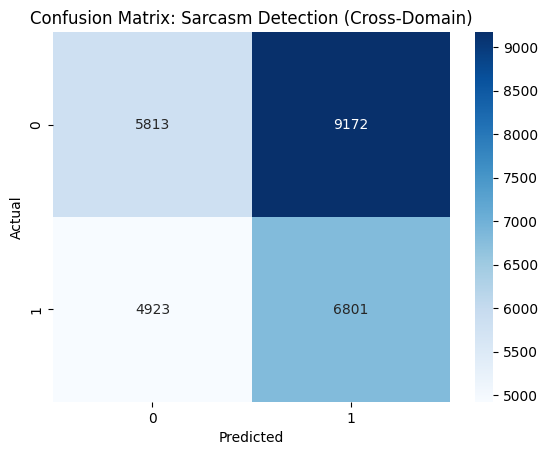

In [ ]:
import seaborn as sns

cm = pd.crosstab(
    headline_df["is_sarcastic"],
    headline_df["roberta_prediction"],
    rownames=["Actual"],
    colnames=["Predicted"]
)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Sarcasm Detection (Cross-Domain)")
plt.show()

In [ ]:
headline_df.to_csv("/content/drive/MyDrive/INST798_Project/headlines_predicted_sentiment.csv")

In [ ]:
headline_df["roberta_emotion"].value_counts()

roberta_emotion
neutral           21004
sadness             743
admiration          710
curiosity           707
disappointment      340
excitement          278
joy                 259
annoyance           245
surprise            240
fear                236
confusion           212
approval            209
disapproval         198
love                172
amusement           163
caring              118
optimism            117
disgust             116
gratitude           116
anger               108
remorse             107
desire               89
realization          88
embarrassment        74
nervousness          54
pride                 6
Name: count, dtype: int64

In [ ]:
headline_df2 = headline_df[headline_df["roberta_emotion"] != "neutral"]

In [ ]:
gt_counts = headline_df.groupby(["roberta_emotion", "is_sarcastic"]).size().unstack(fill_value=0)
pred_counts = headline_df.groupby(["roberta_emotion", "roberta_prediction"]).size().unstack(fill_value=0)

In [ ]:
combined2 = pd.DataFrame({
    "GT_Not_Sarcastic": gt_counts.get(0, 0),
    "GT_Sarcastic": gt_counts.get(1, 0),
    "Pred_Not_Sarcastic": pred_counts.get(0, 0),
    "Pred_Sarcastic": pred_counts.get(1, 0)
})

In [ ]:
combined2

GT_Not_Sarcastic  GT_Sarcastic  Pred_Not_Sarcastic  \
roberta_emotion                                                       
admiration                    475           235                 397   
amusement                     119            44                  63   
anger                          20            88                  22   
annoyance                     104           141                  54   
approval                      163            46                  69   
caring                         93            25                  43   
confusion                     114            98                  62   
curiosity                     649            58                 198   
desire                         46            43                  39   
disappointment                163           177                 128   
disapproval                   151            47                  59   
disgust                        55            61                  36   
embarrassment                  30            44                  28   
excitement                    136           142                 115   
fear                          112           124                 106   
gratitude                      80            36                  54   
joy                           118           141                 112   
love                          119            53                  66   
nervousness                    20            34                  27   
neutral                     11564          9440                8496   
optimism                       51            66                  53   
pride                           2             4                   5   
realization                    33            55                   7   
remorse                        45            62                  40   
sadness                       409           334                 358   
surprise                      114           126                  99   

                 Pred_Sarcastic  
roberta_emotion                  
admiration                  313  
amusement                   100  
anger                        86  
annoyance                   191  
approval                    140  
caring                       75  
confusion                   150  
curiosity                   509  
desire                       50  
disappointment              212  
disapproval                 139  
disgust                      80  
embarrassment                46  
excitement                  163  
fear                        130  
gratitude                    62  
joy                         147  
love                        106  
nervousness                  27  
neutral                   12508  
optimism                     64  
pride                         1  
realization                  81  
remorse                      67  
sadness                     385  
surprise                    141

In [ ]:
gt_counts = headline_df2.groupby(["roberta_emotion", "is_sarcastic"]).size().unstack(fill_value=0)
pred_counts = headline_df2.groupby(["roberta_emotion", "roberta_prediction"]).size().unstack(fill_value=0)

In [ ]:
combined = pd.DataFrame({
    "GT_Not_Sarcastic": gt_counts.get(0, 0),
    "GT_Sarcastic": gt_counts.get(1, 0),
    "Pred_Not_Sarcastic": pred_counts.get(0, 0),
    "Pred_Sarcastic": pred_counts.get(1, 0)
})

<Figure size 1600x800 with 0 Axes>

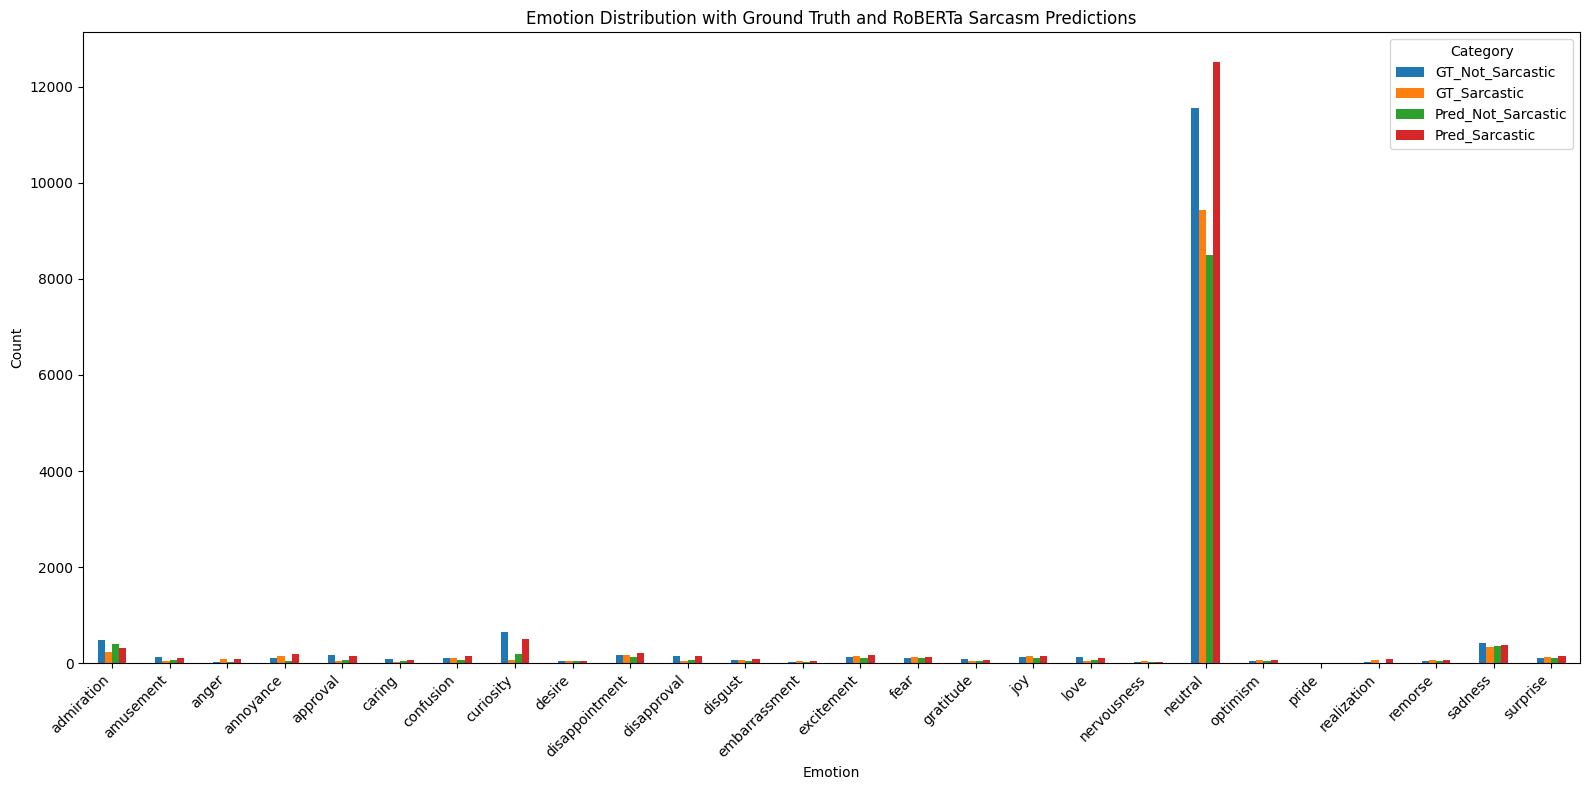

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
combined.plot(kind="bar", figsize=(16, 8))

plt.title("Emotion Distribution with Ground Truth and RoBERTa Sarcasm Predictions")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Category")

plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

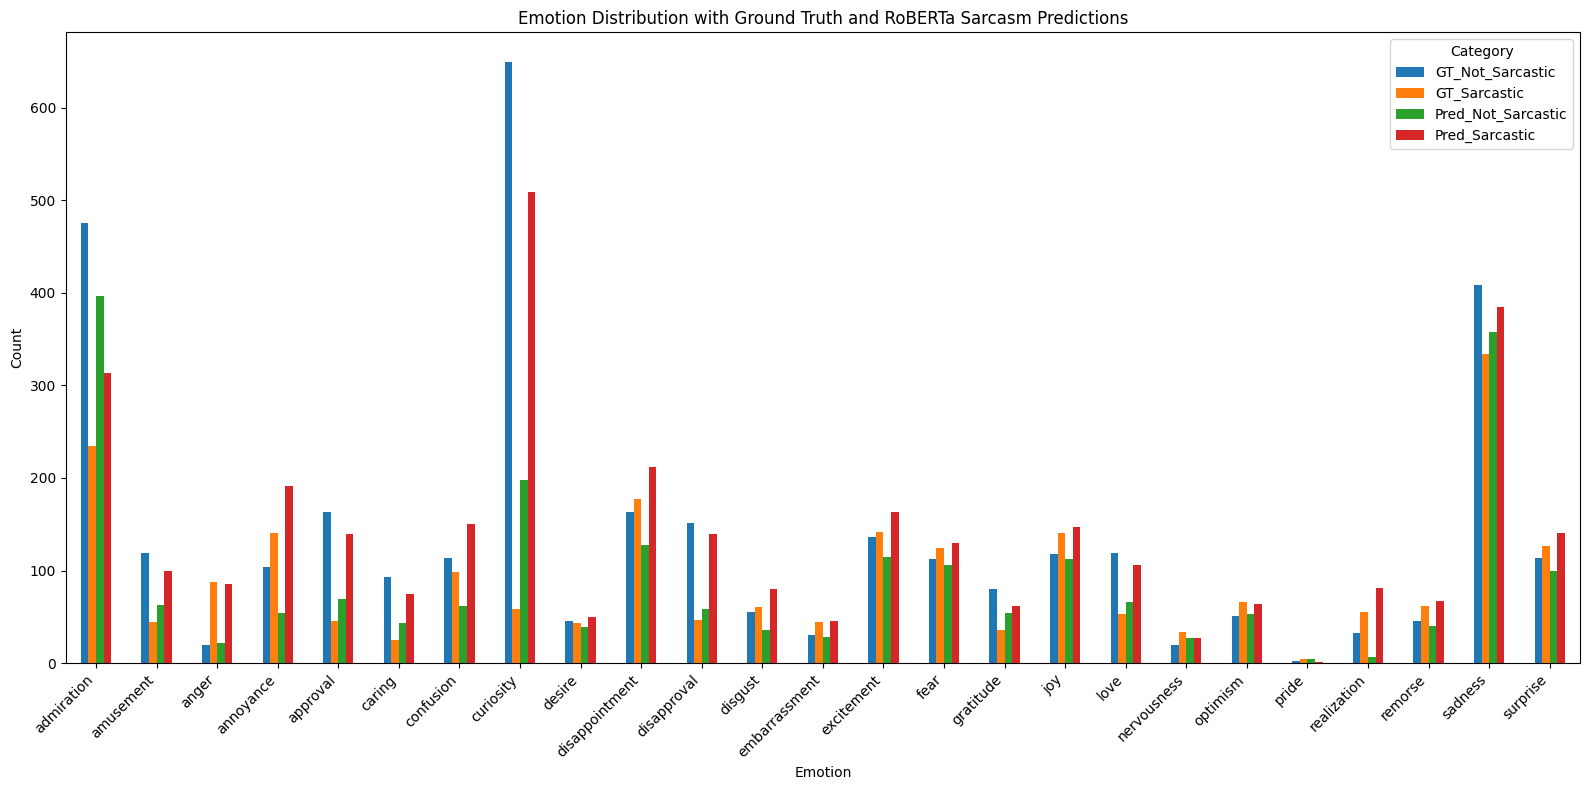

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
combined.plot(kind="bar", figsize=(16, 8))

plt.title("Emotion Distribution with Ground Truth and RoBERTa Sarcasm Predictions")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Category")

plt.tight_layout()
plt.show()